code based on: [How to align faces with OpenCV in Python](https://datahacker.rs/010-how-to-align-faces-with-opencv-in-python/)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

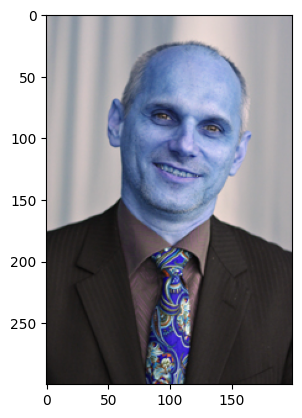

In [3]:
img = cv2.imread('./kdmfi-kjp-ktvs-turany/photos/leginusova1-ktvs.jpg')
img = cv2.imread('./photos/AIN extra_Barbora Cimrova.jpg')
img = cv2.imread('./photos/KTVS_leginusova1-ktvs.jpg')
img = cv2.imread('./photos/MAT_kollar53.jpg')
img = cv2.imread('./photos/AIN_Roman Durikovic.jpg')
plt.imshow(img)

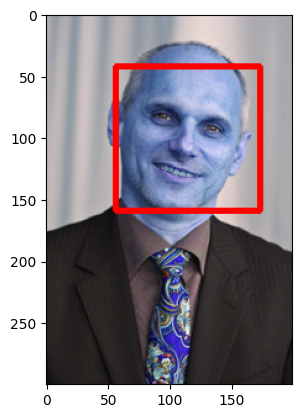

In [4]:
grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(grayscale, 1.1, 4)

# in case more faces were detected select the largest one (or maybe try to get confidence out of detectMultiScale)
face = max(faces, key=lambda contour: contour[2] * contour[3])

original_face = face.copy()

x , y,  w,  h = face
cv2.rectangle(img, (x,y) ,(x+w, y+h), (255,0,0), 3)
plt.imshow(img)

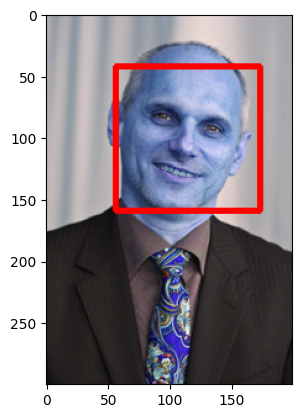

In [5]:
# crop picture to show only head area (detected face and some neighbourhood)
x , y,  w,  h = face
center_x, center_y = x + w // 2, y + h // 2

scaling_factor = 1.5
W = int(w * scaling_factor)
H = int(h * scaling_factor)
X = center_x - W//2
Y = center_y - H//2

pic_height, pic_width = img.shape[:2]
#pic_height, pic_width = 5, 5
if X > 0 and Y > 0 and X+W < pic_width and Y+H < pic_height:
    cropped_face = img[Y:Y + H, X:X + W]
    face[0] = (W - w) // 2
    face[1] = (H - h) // 2
    DX = DY = None
else:
    cropped_face = img
    DX, DY = x, y

#cropped_face = img[Y:Y+H, X:X+W]
plt.imshow(cropped_face)

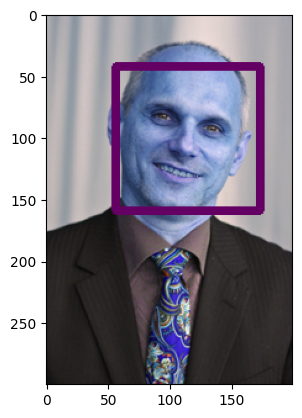

In [6]:
# adjust detected `face` coords to the new dimensions

#face[0] = (W - w)//2
#face[1] = (H - h)//2

x , y,  w,  h = face
cv2.rectangle(cropped_face, (x,y) ,(x+w, y+h), (100,0,100), 5)
plt.imshow(cropped_face)

In [7]:
x , y,  w,  h = face
grayscale = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2GRAY)
#roi_gray = grayscale
#roi_color = cropped_face
roi_gray = grayscale[y:(y+h), x:(x+w)]
roi_color = cropped_face[y:(y+h), x:(x+w)]

[24 24 24]
[2.2866869  2.99736232 1.54856494]
[[22 25 30 30]
 [66 38 25 25]
 [53 28 41 41]]
[array([53, 28, 41, 41]), array([22, 25, 30, 30]), array([66, 38, 25, 25])]
[[22 25 30 30]
 [66 38 25 25]
 [53 28 41 41]]

(22, 25, 30, 30) (53, 28, 41, 41)


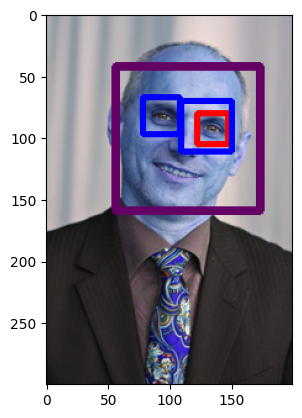

In [8]:
# detect eyes

eyes3, rejectLevels, levelWeights = eye_cascade.detectMultiScale3(roi_gray, scaleFactor=1.0485258, minNeighbors=6,outputRejectLevels = 1)
eyes3, rejectLevels, levelWeights = eye_cascade.detectMultiScale3(roi_gray, scaleFactor=1.05, minNeighbors=4,outputRejectLevels = 1)

print(rejectLevels)
print(levelWeights)
print(eyes3)
print([ey for _, ey in sorted(zip(levelWeights, eyes3))])

eyes = eye_cascade.detectMultiScale(roi_gray, 1.05, 4)

for eye in eyes:
    xe, ye, we, he = eye
    cv2.rectangle(roi_color, (xe, ye), (xe + we, ye + he), (255, 0, 0), 3)

print(eyes)
# select contours that are located in the upper half of the face
eyes = [(ex , ey,  ew,  eh) for  (ex , ey,  ew,  eh) in eyes if ey < (h//2)]

# select the two largest contours
eyes = sorted(eyes, key=lambda contour: contour[2] * contour[3])[-2:]

left_eye, right_eye = eyes if eyes[0][0] < eyes[1][0] else eyes[::-1]
print()
print(left_eye, right_eye)
for (ex , ey,  ew,  eh) in eyes:
    cv2.rectangle(roi_color, (ex,ey) ,(ex+ew, ey+eh), (0,0,255), 3)

plt.imshow(cropped_face)

In [9]:
# get the centers of eyes
left_eye_center = (left_eye[0] + left_eye[2] // 2, left_eye[1] + left_eye[3] // 2)
left_eye_x = left_eye_center[0]
left_eye_y = left_eye_center[1]

right_eye_center = (right_eye[0] + right_eye[2] // 2, right_eye[1] + right_eye[3] // 2)
right_eye_x = right_eye_center[0]
right_eye_y = right_eye_center[1]

cv2.circle(roi_color, left_eye_center, 5, (255, 0, 0) , -1)
cv2.circle(roi_color, right_eye_center, 5, (255, 0, 0) , -1)
cv2.line(roi_color,right_eye_center, left_eye_center,(0,200,200),3)
pass

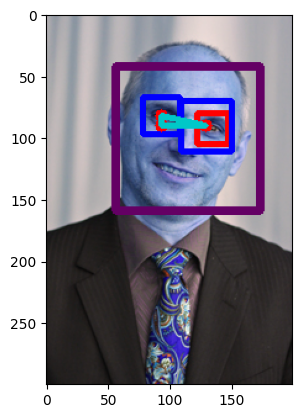

In [10]:
if left_eye_y > right_eye_y:
   A = right_eye_x, left_eye_y
   direction = -1
else:
   A = left_eye_x, right_eye_y
   direction = 1

cv2.circle(roi_color, A, 5, (255, 0, 0) , -1)
cv2.line(roi_color,right_eye_center, left_eye_center,(0,200,200),3)
cv2.line(roi_color,left_eye_center, A,(0,200,200),3)
cv2.line(roi_color,right_eye_center, A,(0,200,200),3)
plt.imshow(cropped_face)

In [11]:
# calculate the rotation angle
delta_x = right_eye_x - left_eye_x
delta_y = right_eye_y - left_eye_y
angle = np.arctan(delta_y/delta_x)
angle = (angle * 180) / np.pi

(56, 42)
(2, 3)


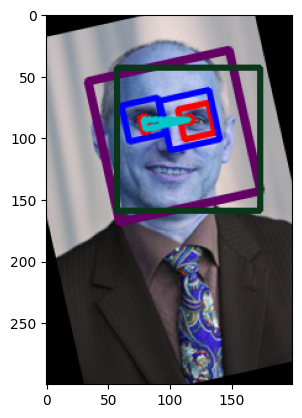

In [12]:
h, w = cropped_face.shape[:2]
center = (w // 2, h // 2)

M = cv2.getRotationMatrix2D(center, angle, 1.0)

rotated = cv2.warpAffine(cropped_face, M, (w, h))
face_points = [ (original_face[0], original_face[1]),
                (original_face[0]+original_face[2], original_face[1]),
                (original_face[0], original_face[1] + original_face[3]),
                (original_face[0]+original_face[2],original_face[1] + original_face[3])]

print(face_points[0])
print(M.shape)
face_rotated = [ M @ np.array(point+(1,)) for point in face_points]

face_rotated2 = [ M.T @ np.array(point) for point in face_rotated]



face_rotated = [center[0] - face[2]//2, center[1] - face[3]//2, face[2], face[3]]

faces = face_cascade.detectMultiScale(grayscale, 1.1, 4)

# in case more faces were detected select the largest one (or maybe try to get confidence out of detectMultiScale)
face_rotated = max(faces, key=lambda contour: contour[2] * contour[3])

x, y, w, h = face_rotated
cv2.rectangle(rotated, (x,y) ,(x+w, y+h), (10,55,25), 3)
plt.imshow(rotated)

True

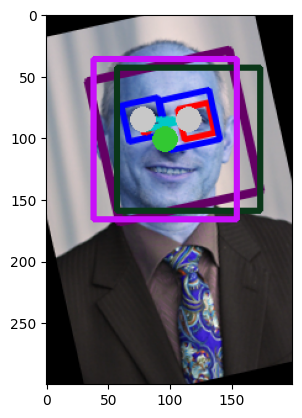

In [13]:
x, y, w, h = face_rotated
dx, dy = int(w*(scaling_factor-1)//2), int(h*(scaling_factor-1)//2)
if DX is not None:
    dx, dy = DX, DY

rotated_left =  M @ (np.array([left_eye_center[0], left_eye_center[1], 1]) + np.array([dx, dy, 0]) )
rotated_left = rotated_left.astype(int)
rotated_right =  M @ (np.array([right_eye_center[0], right_eye_center[1], 1]) + np.array([dx, dy, 0]) )
rotated_right = rotated_right.astype(int)

cv2.circle(rotated, rotated_left, 5, (200, 200, 200) , 10)
cv2.circle(rotated, rotated_right, 5, (200, 199, 199) , 10)

center_x = (rotated_left[0] + rotated_right[0] ) // 2
center_y = y + h // 2
cv2.circle(rotated, np.array([center_x, center_y]), 5, (50, 200, 50) , 10)

ratio = 1.125

w = w
h = int(ratio * w)


centered_resized_face = (center_x - w // 2, center_y - h // 2, w, h)
x, y, w, h = centered_resized_face

cv2.rectangle(rotated, (x,y) ,(x+w, y+h), (200,15,250), 3)
plt.imshow(rotated)

w_px = 120
h_px = int(w_px*ratio)

cropped = rotated[y:y+h, x:x+w]
resized = cv2.resize(cropped, (w_px, h_px))
cv2.imwrite("crop.jpg", resized)